In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
import re
# from pandasql import sqldf
from lxml import html
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import scipy.stats
import pandas_datareader as web
import matplotlib.dates as mdates
plt.style.use('bmh')

In [ ]:
# !pip install pandasql

# Loading Energy Data
>- loading data using the requests.get(url) directly from CAISO webpage
>- Energy data for the four utility companies dates to 2019, the recent data being July of 2023
>- Just as a note, I'll be using this years hourly data as the testing point while the 4 years pervious to 2023 would be used as a training set

In [ ]:
#Storing the data URLs; the URL has data from 2019-2022 upto july os 2023
url = "http://www.caiso.com/planning/Pages/ReliabilityRequirements/Default.aspx"

#Requesting the data and getting a response from both the URls
r = requests.get(url)

#getting the html content
tree = html.fromstring(r.content)

#Using xpath and web scrapping to get the exact location of the data files on the website by using inspect method on the websites
file = tree.xpath('//*[@id="NodeTempate"]/a[@class="ISOTreeNodeTxt"]//@href')

In [ ]:
#Checking if files were imported correctly; the hourly data is stored in all files starting with "Historical..."
hourly_data=[]
for doc in file:
    if "Historical" in doc:
        print(doc)
        hourly_data.append(doc)

/Documents/HistoricalYearAheadResourceAdequacyAggregateData.xlsx
/Documents/HistoricalResourceAdequacyImportAggregateData.xlsx
/Documents/HistoricalEMSHourlyLoadforJuly2023.xlsx
/Documents/HistoricalEMSHourlyLoadforJune2023.xlsx
/Documents/HistoricalEMSHourlyLoadforMay2023.xlsx
/Documents/HistoricalEMSHourlyLoadforApril2023.xlsx
/Documents/HistoricalEMSHourlyLoadforMarch2023.xlsx
/Documents/HistoricalEMSHourlyLoadforFebruary2023.xlsx
/Documents/HistoricalEMSHourlyLoadforJanuary2023.xlsx
/Documents/HistoricalEMSHourlyLoad-2022.xlsx
/Documents/HistoricalEMSHourlyLoad-2021.xlsx
/Documents/HistoricalEMSHourlyLoad-2020.xlsx
/Documents/HistoricalEMSHourlyLoad-2019.xlsx


In [ ]:
# reading in to files for the last four years and
hourly_dict = {}
for doc in file:
    if "Historical" in doc:
        year_match = re.search(r"\d{4}", doc)  # Extract the year from the file name
        if year_match:
            year = year_match.group()
            key = 'hourly_load' + '_' + year
            hourly_dict[key] = pd.read_excel('http://www.caiso.com' + doc)

In [ ]:
hourly_dict.keys()

dict_keys(['hourly_load_2023', 'hourly_load_2022', 'hourly_load_2021', 'hourly_load_2020', 'hourly_load_2019'])

In [ ]:
hourly_df = pd.concat(hourly_dict, axis='rows', ignore_index=True)

In [ ]:
#Although 2023 data isn't complete with having 7 months data, df shape should be higher than 35,808
hourly_df.shape

(35808, 10)

In [ ]:
hourly_df.head()

,Date,HR,PGE,SCE,SDGE,VEA,CAISO,HE,CAISO Total,Unnamed: 7
0,2023-01-01,1.0,9762.243994,9423.627669,2051.813381,64.478279,21302.162944,NaN,NaN,NaN
1,2023-01-01,2.0,9705.411413,9047.385452,1987.566918,63.386680,20803.750237,NaN,NaN,NaN
2,2023-01-01,3.0,9539.147198,8795.717097,1900.535271,64.666820,20300.078086,NaN,NaN,NaN
3,2023-01-01,4.0,9372.682285,8583.525353,1893.322396,65.390935,19914.921017,NaN,NaN,NaN
4,2023-01-01,5.0,9438.792313,8612.092143,1859.285546,65.672430,19975.842246,NaN,NaN,NaN


In [ ]:
# Inspecting for 2023 data we can see that only 744 instances were recorded and only january exists in the created hourly_df
count_2023 = len(hourly_df[hourly_df['Date'].dt.year == 2023])
count_2023

744

In [ ]:
hourly_df['Unnamed: 7'].isna().sum()

35802

In [ ]:
#Will be dropping 2023 from the hourly_df
hourly_df= hourly_df[hourly_df['Date'].dt.year != 2023]

In [ ]:
#Will also be dropping Unnamed: 7 as a column without much information and only 3 instances recorded
hourly_df.drop('Unnamed: 7', axis=1, inplace=True)

In [ ]:
hourly_df.shape

(35064, 9)

In [ ]:
# Checking for other null values and seems like we've two instances of hours as HE represents hourly energy and HR is extracted from Date
# We also have two CAISO entries we can keep one and calculate the null entries by adding the utility companies total
hourly_df.isna().sum()

Date               0
HR             17544
PGE                0
SCE                0
SDGE               0
VEA                0
CAISO          17544
HE             17520
CAISO Total    17520
dtype: int64

In [ ]:
hourly_df.drop(['CAISO Total', 'HE', 'HR'], axis=1, inplace=True)

In [ ]:
hourly_df.head()

,Date,PGE,SCE,SDGE,VEA,CAISO
744,2022-01-01,10194.36,9931.73,2084.72,92.85,22303.67
745,2022-01-01,9864.37,9542.54,1989.79,94.39,21491.08
746,2022-01-01,9640.65,9386.28,1918.94,95.85,21041.72
747,2022-01-01,9811.09,9136.57,1831.52,96.77,20875.96
748,2022-01-01,9832.34,9150.23,1818.13,100.71,20901.42


In [ ]:
#Since we've null values in CAISO and its a total of the region participating utilities, we'll creat a function to replace Nan or null with total value
# Iterate over each row in the DataFrame
for index, row in hourly_df.iterrows():
    # Checks if value is null or NaN for CAISO
    if pd.isnull(row['CAISO']):
        # Calculates the sum of values from other columns
        total_sum = row['PGE'] + row['SCE'] + row['SDGE'] + row['VEA']
        # FillS the empty CAISO value with the calculated sum
        hourly_df.at[index, 'CAISO'] = total_sum

In [ ]:
#We can see that CAISO no longer has empty values
hourly_df.isna().sum()

Date     0
PGE      0
SCE      0
SDGE     0
VEA      0
CAISO    0
dtype: int64

In [ ]:
#Before filling in for hr column I'll change the date to datetime and use it as index
hourly_df['Date'] = pd.to_datetime(hourly_df['Date'])
hourly_df.sort_values('Date', inplace=True)

In [ ]:
# Define the start and end points of the time sequence since our date column doesnt have hours
start_date = pd.Timestamp(year=2019, month=1, day=1, hour=0, minute=0, second=0)
end_date = pd.Timestamp(year=2022, month=12, day=31, hour=23, minute=59, second=59)

time_sequence = pd.date_range(start=start_date, end=end_date, freq='H')

df_time = pd.DataFrame({'datetime':time_sequence})

In [ ]:
# Extract the year, month, day, and hour information from the datetime column
df_time['year'] = df_time['datetime'].dt.year
df_time['month'] = df_time['datetime'].dt.month
df_time['day'] = df_time['datetime'].dt.day
df_time['hour'] = df_time['datetime'].dt.hour

In [ ]:
# Ensure data types match
hourly_df["Date"] = pd.to_datetime(hourly_df["Date"])
df_time["datetime"] = pd.to_datetime(df_time["datetime"])

In [ ]:
hourly_df.set_index("Date", inplace =True)

In [ ]:
df_time.set_index("datetime", inplace=True)

In [ ]:
hourly_df

,PGE,SCE,SDGE,VEA,CAISO
Date,,,,,
2019-01-01,10543.794826,10829.111952,2372.497411,95.325563,23840.729751
2019-01-01,11649.592015,11893.453736,2698.751137,99.887433,26341.684321
2019-01-01,11875.814143,11992.329483,2777.672120,99.879848,26745.695594
2019-01-01,11997.283952,12030.146692,2799.193829,99.243393,26925.867866
2019-01-01,11688.500889,11692.302915,2761.883322,98.852646,26241.539771
...,...,...,...,...,...
2022-12-31,9713.140000,8830.890000,1848.860000,59.980000,20452.860000
2022-12-31,9833.260000,8994.520000,1857.700000,59.210000,20744.690000
2022-12-31,9781.560000,9632.460000,2035.800000,58.680000,21508.500000


In [ ]:
df_time

,year,month,day,hour
datetime,,,,
2019-01-01 00:00:00,2019,1,1,0
2019-01-01 01:00:00,2019,1,1,1
2019-01-01 02:00:00,2019,1,1,2
2019-01-01 03:00:00,2019,1,1,3
2019-01-01 04:00:00,2019,1,1,4
...,...,...,...,...
2022-12-31 19:00:00,2022,12,31,19
2022-12-31 20:00:00,2022,12,31,20
2022-12-31 21:00:00,2022,12,31,21


In [ ]:
# Both df_time and hourly_df have the same number and are squential, will be merging them to have the hours column
hourly_df.reset_index(inplace=True)
df_time.reset_index(inplace=True)
hourly = pd.concat([hourly_df,df_time], axis= 1)
hourly.head()

,Date,PGE,SCE,SDGE,VEA,CAISO,datetime,year,month,day,hour
0,2019-01-01,10543.794826,10829.111952,2372.497411,95.325563,23840.729751,2019-01-01 00:00:00,2019,1,1,0
1,2019-01-01,11649.592015,11893.453736,2698.751137,99.887433,26341.684321,2019-01-01 01:00:00,2019,1,1,1
2,2019-01-01,11875.814143,11992.329483,2777.672120,99.879848,26745.695594,2019-01-01 02:00:00,2019,1,1,2
3,2019-01-01,11997.283952,12030.146692,2799.193829,99.243393,26925.867866,2019-01-01 03:00:00,2019,1,1,3
4,2019-01-01,11688.500889,11692.302915,2761.883322,98.852646,26241.539771,2019-01-01 04:00:00,2019,1,1,4


In [ ]:
hourly.shape

(35064, 11)

In [ ]:
# Dropping original Date, keeing datetime since it has the time down to the hour
hourly.drop('Date', axis=1, inplace=True)

In [ ]:
hourly

,PGE,SCE,SDGE,VEA,CAISO,datetime,year,month,day,hour
0,10543.794826,10829.111952,2372.497411,95.325563,23840.729751,2019-01-01 00:00:00,2019,1,1,0
1,11649.592015,11893.453736,2698.751137,99.887433,26341.684321,2019-01-01 01:00:00,2019,1,1,1
2,11875.814143,11992.329483,2777.672120,99.879848,26745.695594,2019-01-01 02:00:00,2019,1,1,2
3,11997.283952,12030.146692,2799.193829,99.243393,26925.867866,2019-01-01 03:00:00,2019,1,1,3
4,11688.500889,11692.302915,2761.883322,98.852646,26241.539771,2019-01-01 04:00:00,2019,1,1,4
...,...,...,...,...,...,...,...,...,...,...
35059,9713.140000,8830.890000,1848.860000,59.980000,20452.860000,2022-12-31 19:00:00,2022,12,31,19
35060,9833.260000,8994.520000,1857.700000,59.210000,20744.690000,2022-12-31 20:00:00,2022,12,31,20
35061,9781.560000,9632.460000,2035.800000,58.680000,21508.500000,2022-12-31 21:00:00,2022,12,31,21
35062,11282.210000,10547.930000,2080.700000,60.320000,23971.170000,2022-12-31 22:00:00,2022,12,31,22


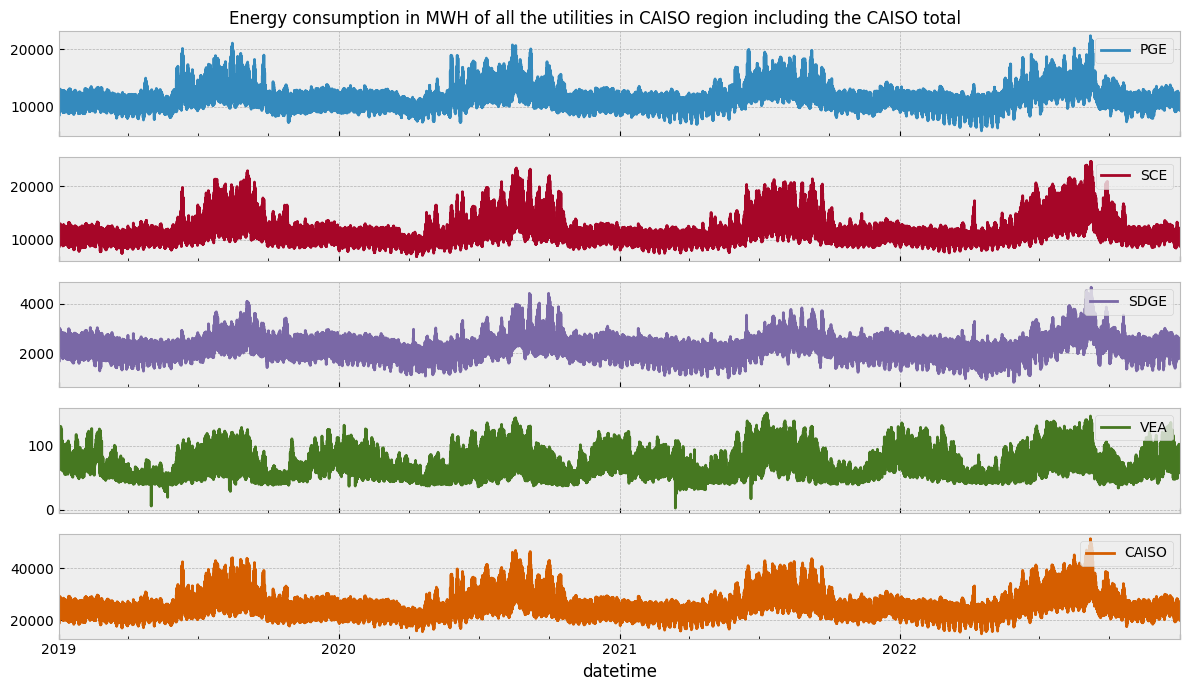

In [ ]:
hourly.set_index('datetime')[['PGE','SCE','SDGE','VEA','CAISO']].plot(subplots = True, figsize = (12,7))
[ax.legend(loc = 1) for ax in plt.gcf().axes]
plt.suptitle('Energy consumption in MWH of all the utilities in CAISO region including the CAISO total')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

In [ ]:
hourly.describe().T

,count,mean,std,min,25%,50%,75%,max
PGE,35064.0,11377.011798,2018.506825,5768.620000,9950.271805,11042.388425,12271.052500,22379.07
SCE,35064.0,11574.389346,2598.870305,6818.951874,9790.111622,10962.400000,12396.124513,24658.58
SDGE,35064.0,2181.521902,443.174409,840.176104,1870.028306,2114.490000,2423.938365,4651.75
VEA,35064.0,68.061186,21.026325,2.480000,51.680734,62.884284,80.666632,150.75
CAISO,35064.0,25200.965943,4880.006282,14779.080000,21757.852585,24192.424396,27154.524122,51479.00
year,35064.0,2020.499658,1.117744,2019.000000,2020.000000,2020.000000,2021.000000,2022.00
month,35064.0,6.522930,3.448752,1.000000,4.000000,7.000000,10.000000,12.00
day,35064.0,15.729637,8.800218,1.000000,8.000000,16.000000,23.000000,31.00
hour,35064.0,11.500000,6.922285,0.000000,5.750000,11.500000,17.250000,23.00


In [ ]:
#Saving df as csv
hourly.to_csv('hourly_energy.csv')

# Feature Engineering Data

1.   Will be focused on Sandiego Energy and Gas utility
2.   Weather patterns are easier to catch in small area
3.   Other CAISO companies distribution isnt constat across all areas



In [ ]:
SDGE_hr = pd.read_csv('hourly_energy.csv',usecols=['datetime','SDGE'], parse_dates=['datetime'])

In [ ]:
SDGE_hr.head()

,SDGE,datetime
0,2372.497411,2019-01-01 00:00:00
1,2698.751137,2019-01-01 01:00:00
2,2777.672120,2019-01-01 02:00:00
3,2799.193829,2019-01-01 03:00:00
4,2761.883322,2019-01-01 04:00:00


In [ ]:
SDGE_hr['Date'] = pd.to_datetime(SDGE_hr['datetime'])
SDGE_hr = SDGE_hr.set_index(['datetime'])

In [ ]:
def season_calc(month):
    """adding season based on the data on SDGE's site -> https://www.sdge.com/whenmatters#how-it-works;
       months from June to October are denoted as 'summer' and months from November to May as 'winter'. """
    if month in [6,7,8,9,10]:
        return "summer"
    else:
        return "winter"

In [ ]:
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
SDGE_hr['year'] = SDGE_hr.Date.dt.year
SDGE_hr['month'] = SDGE_hr.Date.dt.month
SDGE_hr['day'] = SDGE_hr.Date.dt.day
SDGE_hr['hour'] = SDGE_hr.Date.dt.hour
SDGE_hr['weekday'] = SDGE_hr.Date.dt.weekday.map(weekdays)
SDGE_hr['season'] = SDGE_hr.Date.dt.month.apply(season_calc)

In [ ]:
SDGE_hr.describe()

,SDGE,year,month,day,hour
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,2181.521902,2020.499658,6.522930,15.729637,11.500000
std,443.174409,1.117744,3.448752,8.800218,6.922285
min,840.176104,2019.000000,1.000000,1.000000,0.000000
25%,1870.028306,2020.000000,4.000000,8.000000,5.750000
50%,2114.490000,2020.000000,7.000000,16.000000,11.500000
75%,2423.938365,2021.000000,10.000000,23.000000,17.250000
max,4651.750000,2022.000000,12.000000,31.000000,23.000000


In [ ]:
SDGE_hr

,SDGE,Date,year,month,day,hour,weekday,season
datetime,,,,,,,,
2019-01-01 00:00:00,2372.497411,2019-01-01 00:00:00,2019,1,1,0,Tuesday,winter
2019-01-01 01:00:00,2698.751137,2019-01-01 01:00:00,2019,1,1,1,Tuesday,winter
2019-01-01 02:00:00,2777.672120,2019-01-01 02:00:00,2019,1,1,2,Tuesday,winter
2019-01-01 03:00:00,2799.193829,2019-01-01 03:00:00,2019,1,1,3,Tuesday,winter
2019-01-01 04:00:00,2761.883322,2019-01-01 04:00:00,2019,1,1,4,Tuesday,winter
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,1848.860000,2022-12-31 19:00:00,2022,12,31,19,Saturday,winter
2022-12-31 20:00:00,1857.700000,2022-12-31 20:00:00,2022,12,31,20,Saturday,winter
2022-12-31 21:00:00,2035.800000,2022-12-31 21:00:00,2022,12,31,21,Saturday,winter


In [ ]:
#Adding holidays column to indicate whether a day was a holiday as per the US calendar or not
cal = calendar()
holidays = cal.holidays(start = SDGE_hr['Date'].min(), end = SDGE_hr['Date'].max())
SDGE_hr['holiday'] = SDGE_hr['Date'].isin(holidays)

In [ ]:
#converting the holiday column to 1 and 0, 1 indicating a holiday and 0 not a holiday; using dictionary and map to achieve this
mapped = {True:1, False:0}
SDGE_hr.holiday = SDGE_hr.holiday.map(mapped)
SDGE_hr.head()

,SDGE,Date,year,month,day,hour,weekday,season,holiday
datetime,,,,,,,,,
2019-01-01 00:00:00,2372.497411,2019-01-01 00:00:00,2019,1,1,0,Tuesday,winter,1
2019-01-01 01:00:00,2698.751137,2019-01-01 01:00:00,2019,1,1,1,Tuesday,winter,0
2019-01-01 02:00:00,2777.672120,2019-01-01 02:00:00,2019,1,1,2,Tuesday,winter,0
2019-01-01 03:00:00,2799.193829,2019-01-01 03:00:00,2019,1,1,3,Tuesday,winter,0
2019-01-01 04:00:00,2761.883322,2019-01-01 04:00:00,2019,1,1,4,Tuesday,winter,0


In [ ]:
column_order =['Date', 'SDGE', 'year', 'month', 'day','hour','weekday', 'season','holiday']
SDGE_hr = SDGE_hr.reindex(columns=column_order)

In [ ]:
SDGE_hr.head()

,Date,SDGE,year,month,day,hour,weekday,season,holiday
datetime,,,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,2372.497411,2019,1,1,0,Tuesday,winter,1
2019-01-01 01:00:00,2019-01-01 01:00:00,2698.751137,2019,1,1,1,Tuesday,winter,0
2019-01-01 02:00:00,2019-01-01 02:00:00,2777.672120,2019,1,1,2,Tuesday,winter,0
2019-01-01 03:00:00,2019-01-01 03:00:00,2799.193829,2019,1,1,3,Tuesday,winter,0
2019-01-01 04:00:00,2019-01-01 04:00:00,2761.883322,2019,1,1,4,Tuesday,winter,0


In [ ]:
#Saving PGE file to csv
SDGE_hr.to_csv('hourly_SDGE.csv')

# Loading Weather data

In [ ]:
#Weather is fetched from https://www.ncei.noaa.gov/cdo-web/datatools/lcd from 2019 until October of 2023
#Using San Diego international airport weather information station #72290023188 since San Diego is a small county
#Airport weather has less noise and hence why it was chosen for this project
weather_df= pd.read_csv('https://www.ncei.noaa.gov/orders/cdo/3505262.csv')

<ipython-input-225-b80b4c1a1781>:4: DtypeWarning: Columns (21,27,28,29,30,31,32,33,37,38,44,50,52,72,89) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df= pd.read_csv('https://www.ncei.noaa.gov/orders/cdo/3505262.csv')


In [ ]:
#Filtering weather data to include the most common hourly indicators and Date stamp for merging with energy data
weather_indicators = ['DATE','HourlyDryBulbTemperature', 'HourlyPrecipitation',
                     'HourlyRelativeHumidity','HourlyWindSpeed']

In [ ]:
weather_hr= weather_df.loc[:,weather_indicators]

In [ ]:
weather_hr.head()

,DATE,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWindSpeed
0,2019-01-01T00:51:00,49.0,0.00,71.0,0.0
1,2019-01-01T01:51:00,47.0,0.00,77.0,5.0
2,2019-01-01T02:51:00,47.0,0.00,63.0,6.0
3,2019-01-01T03:51:00,47.0,0.00,52.0,6.0
4,2019-01-01T04:00:00,47.0,NaN,52.0,6.0


In [ ]:
#Checking for missing values
weather_hr.isna().sum()

DATE                            0
HourlyDryBulbTemperature     1827
HourlyPrecipitation         17294
HourlyRelativeHumidity       1847
HourlyWindSpeed              1827
dtype: int64

In [ ]:
#Changing object type data to numeric for filling missing values and future computation
weather_hr['HourlyDryBulbTemperature'] = pd.to_numeric(weather_hr['HourlyDryBulbTemperature'], errors='coerce')
weather_hr['HourlyPrecipitation'] = pd.to_numeric(weather_hr['HourlyPrecipitation'], errors='coerce')

In [ ]:
weather_hr.describe()

,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWindSpeed
count,58937.000000,41572.000000,58939.000000,58959.000000
mean,63.944229,0.002379,71.233920,5.422734
std,7.514476,0.017865,15.728301,4.026263
min,38.000000,0.000000,6.000000,0.000000
25%,59.000000,0.000000,64.000000,3.000000
50%,64.000000,0.000000,73.000000,6.000000
75%,69.000000,0.000000,82.000000,8.000000
max,97.000000,0.510000,100.000000,37.000000


In [ ]:
#Although percipitation is valuable, 75% % of its values are missing and will therfore drop the column
weather_hr.drop(['HourlyPrecipitation'], axis=1, inplace=True)

In [ ]:
# Since our data is ordered by the hour and weather can flactuate we'll be using quadratic interpolate to fill in missing values
# HourlyWindSpeed has outlier values and will instead be using bfill instead of interpolation method
weather_hr['HourlyDryBulbTemperature'] = weather_hr['HourlyDryBulbTemperature'].interpolate(method='quadratic')
weather_hr['HourlyRelativeHumidity'] = weather_hr['HourlyRelativeHumidity'].interpolate(method='quadratic')
weather_hr['HourlyWindSpeed'] = weather_hr['HourlyWindSpeed'].fillna(method='bfill')

In [ ]:
#no longer have null values
weather_hr.isna().sum()

DATE                        0
HourlyDryBulbTemperature    0
HourlyRelativeHumidity      0
HourlyWindSpeed             0
dtype: int64

In [ ]:
#shape is 60786 rows when the years we're looking at should have 35064 hours and the set frequency, columns
weather_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60786 entries, 0 to 60785
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATE                      60786 non-null  object 
 1   HourlyDryBulbTemperature  60786 non-null  float64
 2   HourlyRelativeHumidity    60786 non-null  float64
 3   HourlyWindSpeed           60786 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.9+ MB


In [ ]:
weather_hr['DATE'] = pd.to_datetime(weather_hr['DATE'])
weather_hr = weather_hr[weather_hr['DATE'].dt.year != 2023]

In [ ]:
#Since weather data will be merged with energy data resampling record to hourly bases
hourly_weather = weather_hr.set_index('DATE').resample('H').mean()

In [ ]:
hourly_weather

,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyWindSpeed
DATE,,,
2019-01-01 00:00:00,49.000000,71.000000,0.000000
2019-01-01 01:00:00,47.000000,77.000000,5.000000
2019-01-01 02:00:00,47.000000,63.000000,6.000000
2019-01-01 03:00:00,47.000000,52.000000,6.000000
2019-01-01 04:00:00,46.500000,51.500000,5.500000
...,...,...,...
2022-12-31 19:00:00,61.000000,81.000000,10.000000
2022-12-31 20:00:00,61.000000,78.000000,8.000000
2022-12-31 21:00:00,61.000000,79.500000,10.000000


In [ ]:
hourly_weather.isna().sum()

HourlyDryBulbTemperature    0
HourlyRelativeHumidity      0
HourlyWindSpeed             0
dtype: int64

In [ ]:
hourly_weather.to_csv('hourly_weather.csv')

# Weather and Energy data merged

In [ ]:
SDGE_W = pd.merge(SDGE_hr, hourly_weather, how = 'outer', left_on = 'Date', right_on= 'DATE')

In [ ]:
SDGE_W.to_csv('SDGE_W.csv')